In [1]:
!pip install segmentation-models albumentations

  Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
  Using cached image_classifiers-1.0.0-py3-none-any.whl (19 kB)


In [1]:
%load_ext autoreload
%autoreload 2

# include include folder
import sys
sys.path.append("./miniaturautonomie_lanedetection/include/")
sys.path.append("./include/")

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D, concatenate, AveragePooling1D, Reshape, Activation, add, Conv2DTranspose, BatchNormalization, UpSampling2D, SeparableConv2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.losses import CategoricalCrossentropy, Reduction, BinaryCrossentropy
from tensorflow.keras.layers import Lambda
from tensorflow.keras.activations import softmax
from tensorflow import roll, norm, keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.applications as A

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import os
import fnmatch
import random
import cv2
import json

import supervisely_parser as svp
import grid_parser as gp
from DataGenerator import DataGenerator

import segmentation_models as sm # for simple segmentation architecture
import albumentations as Alb

Segmentation Models: using `keras` framework.


In [2]:
annotation_path = './annotation_v3.0/'
image_path = '/tmp/data/'
packages = ['knuff_main1', 'knuff_main2', 'knuff_main3', 'knuff_hill', 'uni', 'highway', 'knuff_main5', 'knuff_main6']

model_path = './model/ld_autosys.h5'

number_classes = 7 # outer, middle_curb, guide_lane, solid_lane, hold_line, zebra, background
output_width = 640 
output_height = 224 
input_width = 640 
input_height = 240

val_size = 0.2 # percentage
augmentation = True

batch_size = 16
epochs = 40

transform = Alb.Compose([
    Alb.ShiftScaleRotate(p=1.0),
    Alb.RandomContrast(p=0.9),
    Alb.RandomBrightness(limit=[-0.4,0.2], p=0.8)
])

params = {
    'batch_size': batch_size,
    'input_img_size': (480, 640),
    'target_img_size': (output_height, output_width),
    'shuffle': True,
    'n_channels': number_classes,
    'transform': transform
}

# generate absolute list of all img and ann paths
image_paths = []
ann_paths = []
# for package
for index in range(len(packages)):
    image_base_path = f"{image_path}{packages[index]}/"
    annotation_base_path = f"{annotation_path}{packages[index]}/ann/"

    file_list = os.listdir(annotation_base_path)
    pattern = '*.json'
    for filename in file_list:
        if fnmatch.fnmatch(filename, pattern):
            ann_paths.append(os.path.join(annotation_base_path, filename))
            image_name = os.path.splitext(filename)[0]
            image_paths.append(os.path.join(image_base_path, image_name))

            if augmentation:
                ann_paths.append(os.path.join(annotation_base_path, filename))
                image_paths.append(os.path.join(image_base_path, f"{image_name}.aug"))


# split into train and val set
size_all = len(image_paths)
val_samples = int(size_all*val_size)
random.Random(size_all).shuffle(image_paths)
random.Random(size_all).shuffle(ann_paths)

train_input_img_paths = image_paths[:-val_samples]
train_target_ann_paths = ann_paths[:-val_samples]
val_input_img_paths = image_paths[-val_samples:]
val_target_ann_paths = ann_paths[-val_samples:]

print(f"Len train img: {len(train_input_img_paths)} len train ann: {len(train_target_ann_paths)}")
print(f"Len val img: {len(val_input_img_paths)} len val ann: {len(val_target_ann_paths)}")

# Generators
train_gen = DataGenerator(train_input_img_paths, train_target_ann_paths, **params)
val_gen = DataGenerator(val_input_img_paths, val_target_ann_paths, **params)

    

Len train img: 1216 len train ann: 1216
Len val img: 304 len val ann: 304


/home/danielriege/env_train/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/danielriege/env_train/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


16


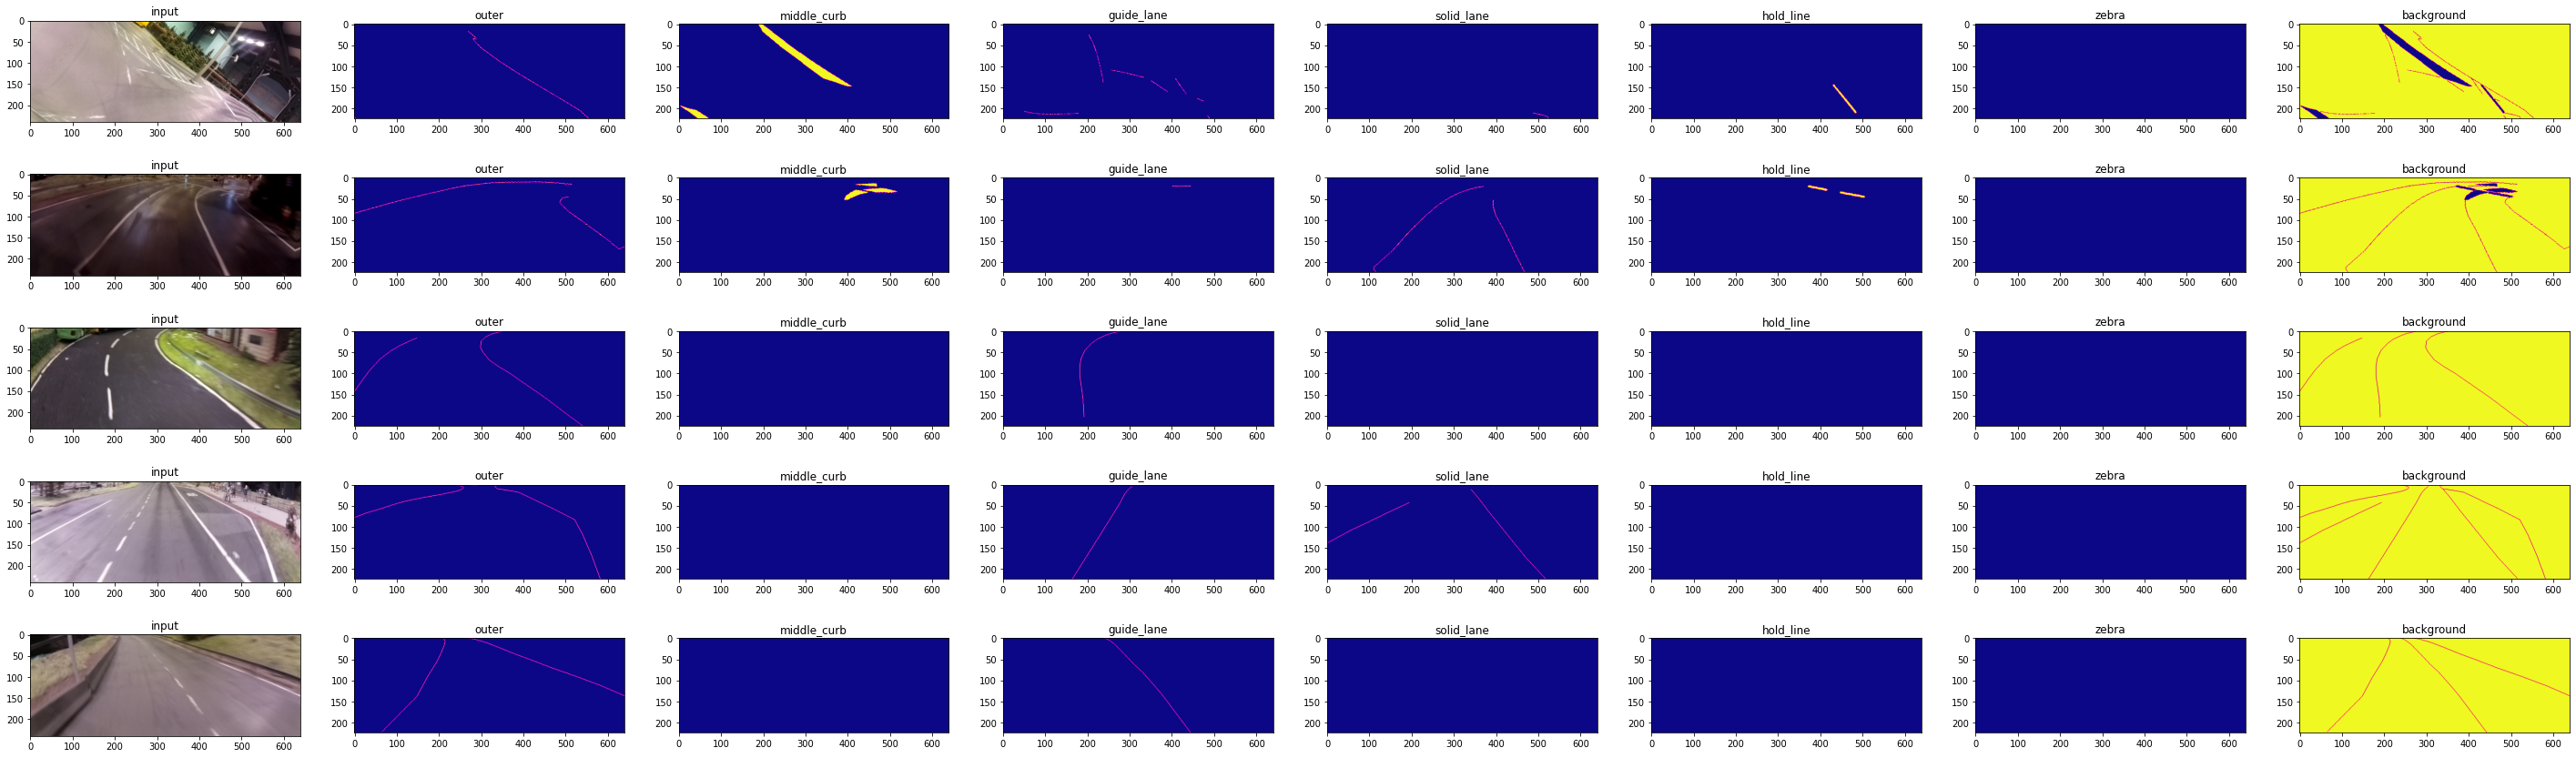

In [4]:
c = 5
f, axs = plt.subplots(c, 8, figsize=(50,c*3))
i = 0

batch_input_test = train_input_img_paths[:c]
batch_target_test = train_target_ann_paths[:c]
images, data = train_gen.data_generation(batch_input_test, batch_target_test)

print(len(images))
for y in range(c):
    axs[y,0].imshow(images[i])
    axs[y,0].title.set_text('input')
    axs[y,1].imshow(data[i][:,:,0], cmap='plasma')
    axs[y,1].title.set_text('outer')
    axs[y,2].imshow(data[i][:,:,1], cmap='plasma')
    axs[y,2].title.set_text('middle_curb')
    axs[y,3].imshow(data[i][:,:,2], cmap='plasma')
    axs[y,3].title.set_text('guide_lane')
    axs[y,4].imshow(data[i][:,:,3], cmap='plasma')
    axs[y,4].title.set_text('solid_lane')
    axs[y,5].imshow(data[i][:,:,4], cmap='plasma')
    axs[y,5].title.set_text('hold_line')
    axs[y,6].imshow(data[i][:,:,5], cmap='plasma')
    axs[y,6].title.set_text('zebra')
    axs[y,7].imshow(data[i][:,:,6], cmap='plasma')
    axs[y,7].title.set_text('background')
    i += 1

In [5]:
def reference(name):
   # base_model = A.ResNet50V2(include_top=False, weights="imagenet", input_shape=(input_height,input_width,3)) 
    #base_model = A.InceptionV3(include_top=False, weights="imagenet", input_shape=(input_height,input_width,3)) 
    base_model = A.VGG16(include_top=False, weights="imagenet", input_shape=(input_height,input_width,3))


    x = Conv2D(256, 1)(base_model.layers[-1].output)
    # previous_block_activation = x

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128,128, 64, 64, 32]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        # x = Activation("relu")(x)
        # x = Conv2DTranspose(filters, 3, padding="same")(x)
        # x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # # Project residual
        # residual = UpSampling2D(2)(previous_block_activation)
        # residual = Conv2D(filters, 1, padding="same")(residual)
        # x = add([x, residual])  # Add back residual
        # previous_block_activation = x  # Set aside next residual
        
    output = Conv2D(number_classes, 1)(x)
    output = Activation('softmax')(output)
    
    model = Model(inputs=base_model.inputs, outputs=output, name=name)
    optimizer = Adam(lr=1e-4) # lr is learning rate
    loss = sm.losses.CategoricalCELoss() + sm.losses.DiceLoss()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[sm.metrics.iou_score]) # mean squared error because it is a regression problem
    #plot_model(model, to_file='%s.png' % (name))
    return model
def test_custom(name):
   # base_model = A.ResNet50V2(include_top=False, weights="imagenet", input_shape=(input_height,input_width,3)) 
   # base_model = A.InceptionV3(include_top=False, weights="imagenet", input_shape=(input_height,input_width,3)) 
    #base_model = A.VGG16(include_top=False, weights="imagenet", input_shape=(input_height,input_width,3))

    #inputs = Input(shape=(input_height,input_width,3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    output = Conv2D(number_classes, 1)(x)
    output = Activation('softmax')(output)
    
    model = Model(inputs=inputs, outputs=output, name=name)
    optimizer = Adam(learnng_rate=1e-4) # lr is learning rate
    loss = sm.losses.CategoricalCELoss() + sm.losses.DiceLoss()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[sm.metrics.iou_score]) # mean squared error because it is a regression problem
    #plot_model(model, to_file='%s.png' % (name))
    return model
keras.backend.clear_session()
model = reference('LANESEGMENTATION_REFERENCE')
#model = custom_unet()
#model = segmentation_model()

print(model.summary())

2021-09-30 16:26:14.440746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:26:14.462014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:26:14.462536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:26:14.464015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "LANESEGMENTATION_REFERENCE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 

/home/danielriege/env_train/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [6]:
# checkpoint
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.compat.v1.Session(config=config)
    
filepath="ld_autosys_checkpoint.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

tf.get_logger().setLevel('ERROR')

history = model.fit(train_gen,
            validation_data=val_gen,
            epochs=epochs,
            use_multiprocessing=False,
            workers=6,
            callbacks=callbacks_list)
model.save(model_path)

2021-09-30 16:26:18.773445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:26:18.773826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:26:18.774116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:26:18.774456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 16:26:18.774756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/40


2021-09-30 16:26:21.511666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-09-30 16:26:23.820716: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-09-30 16:26:23.820763: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.65GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-09-30 16:26:26.648822: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

76/76 [==============================] - 40s 398ms/step - loss: 1.9703 - iou_score: 0.0237 - val_loss: 1.7607 - val_iou_score: 0.0272

Epoch 00001: val_loss improved from inf to 1.76073, saving model to ld_autosys_checkpoint.h5
Epoch 2/40
13/76 [====>.........................] - ETA: 21s - loss: 1.8791 - iou_score: 0.0243

KeyboardInterrupt: 

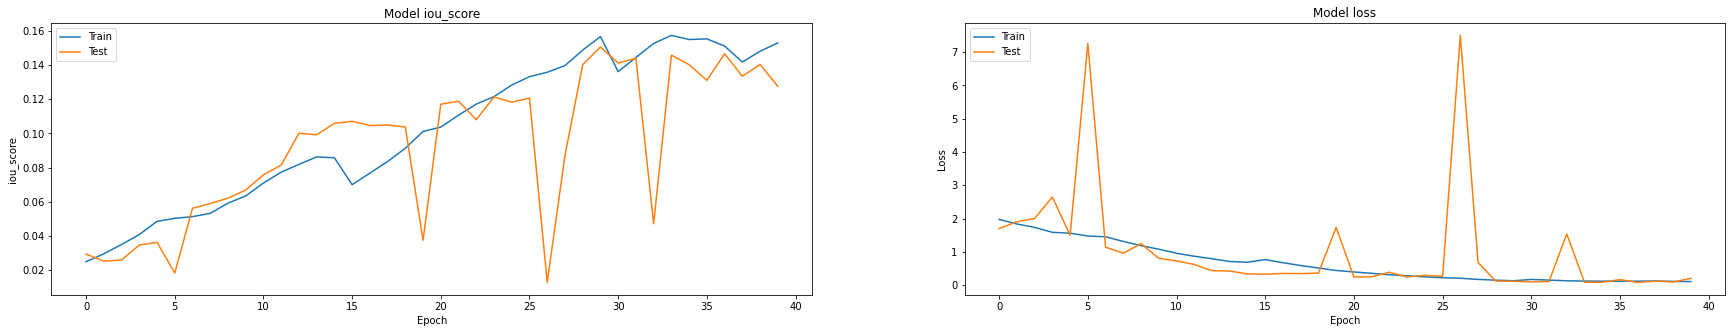

In [22]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('custom.png')
plt.show()



In [23]:
# load model only if not trained in this session\
model = load_model('./ld_autosys_checkpoint.h5', custom_objects={'iou_score':None})

In [24]:
# load some test images
cnt = 10

batch_input_test = train_input_img_paths[:cnt]
batch_target_test = train_target_ann_paths[:cnt]
images, data = train_gen.data_generation(batch_input_test, batch_target_test)

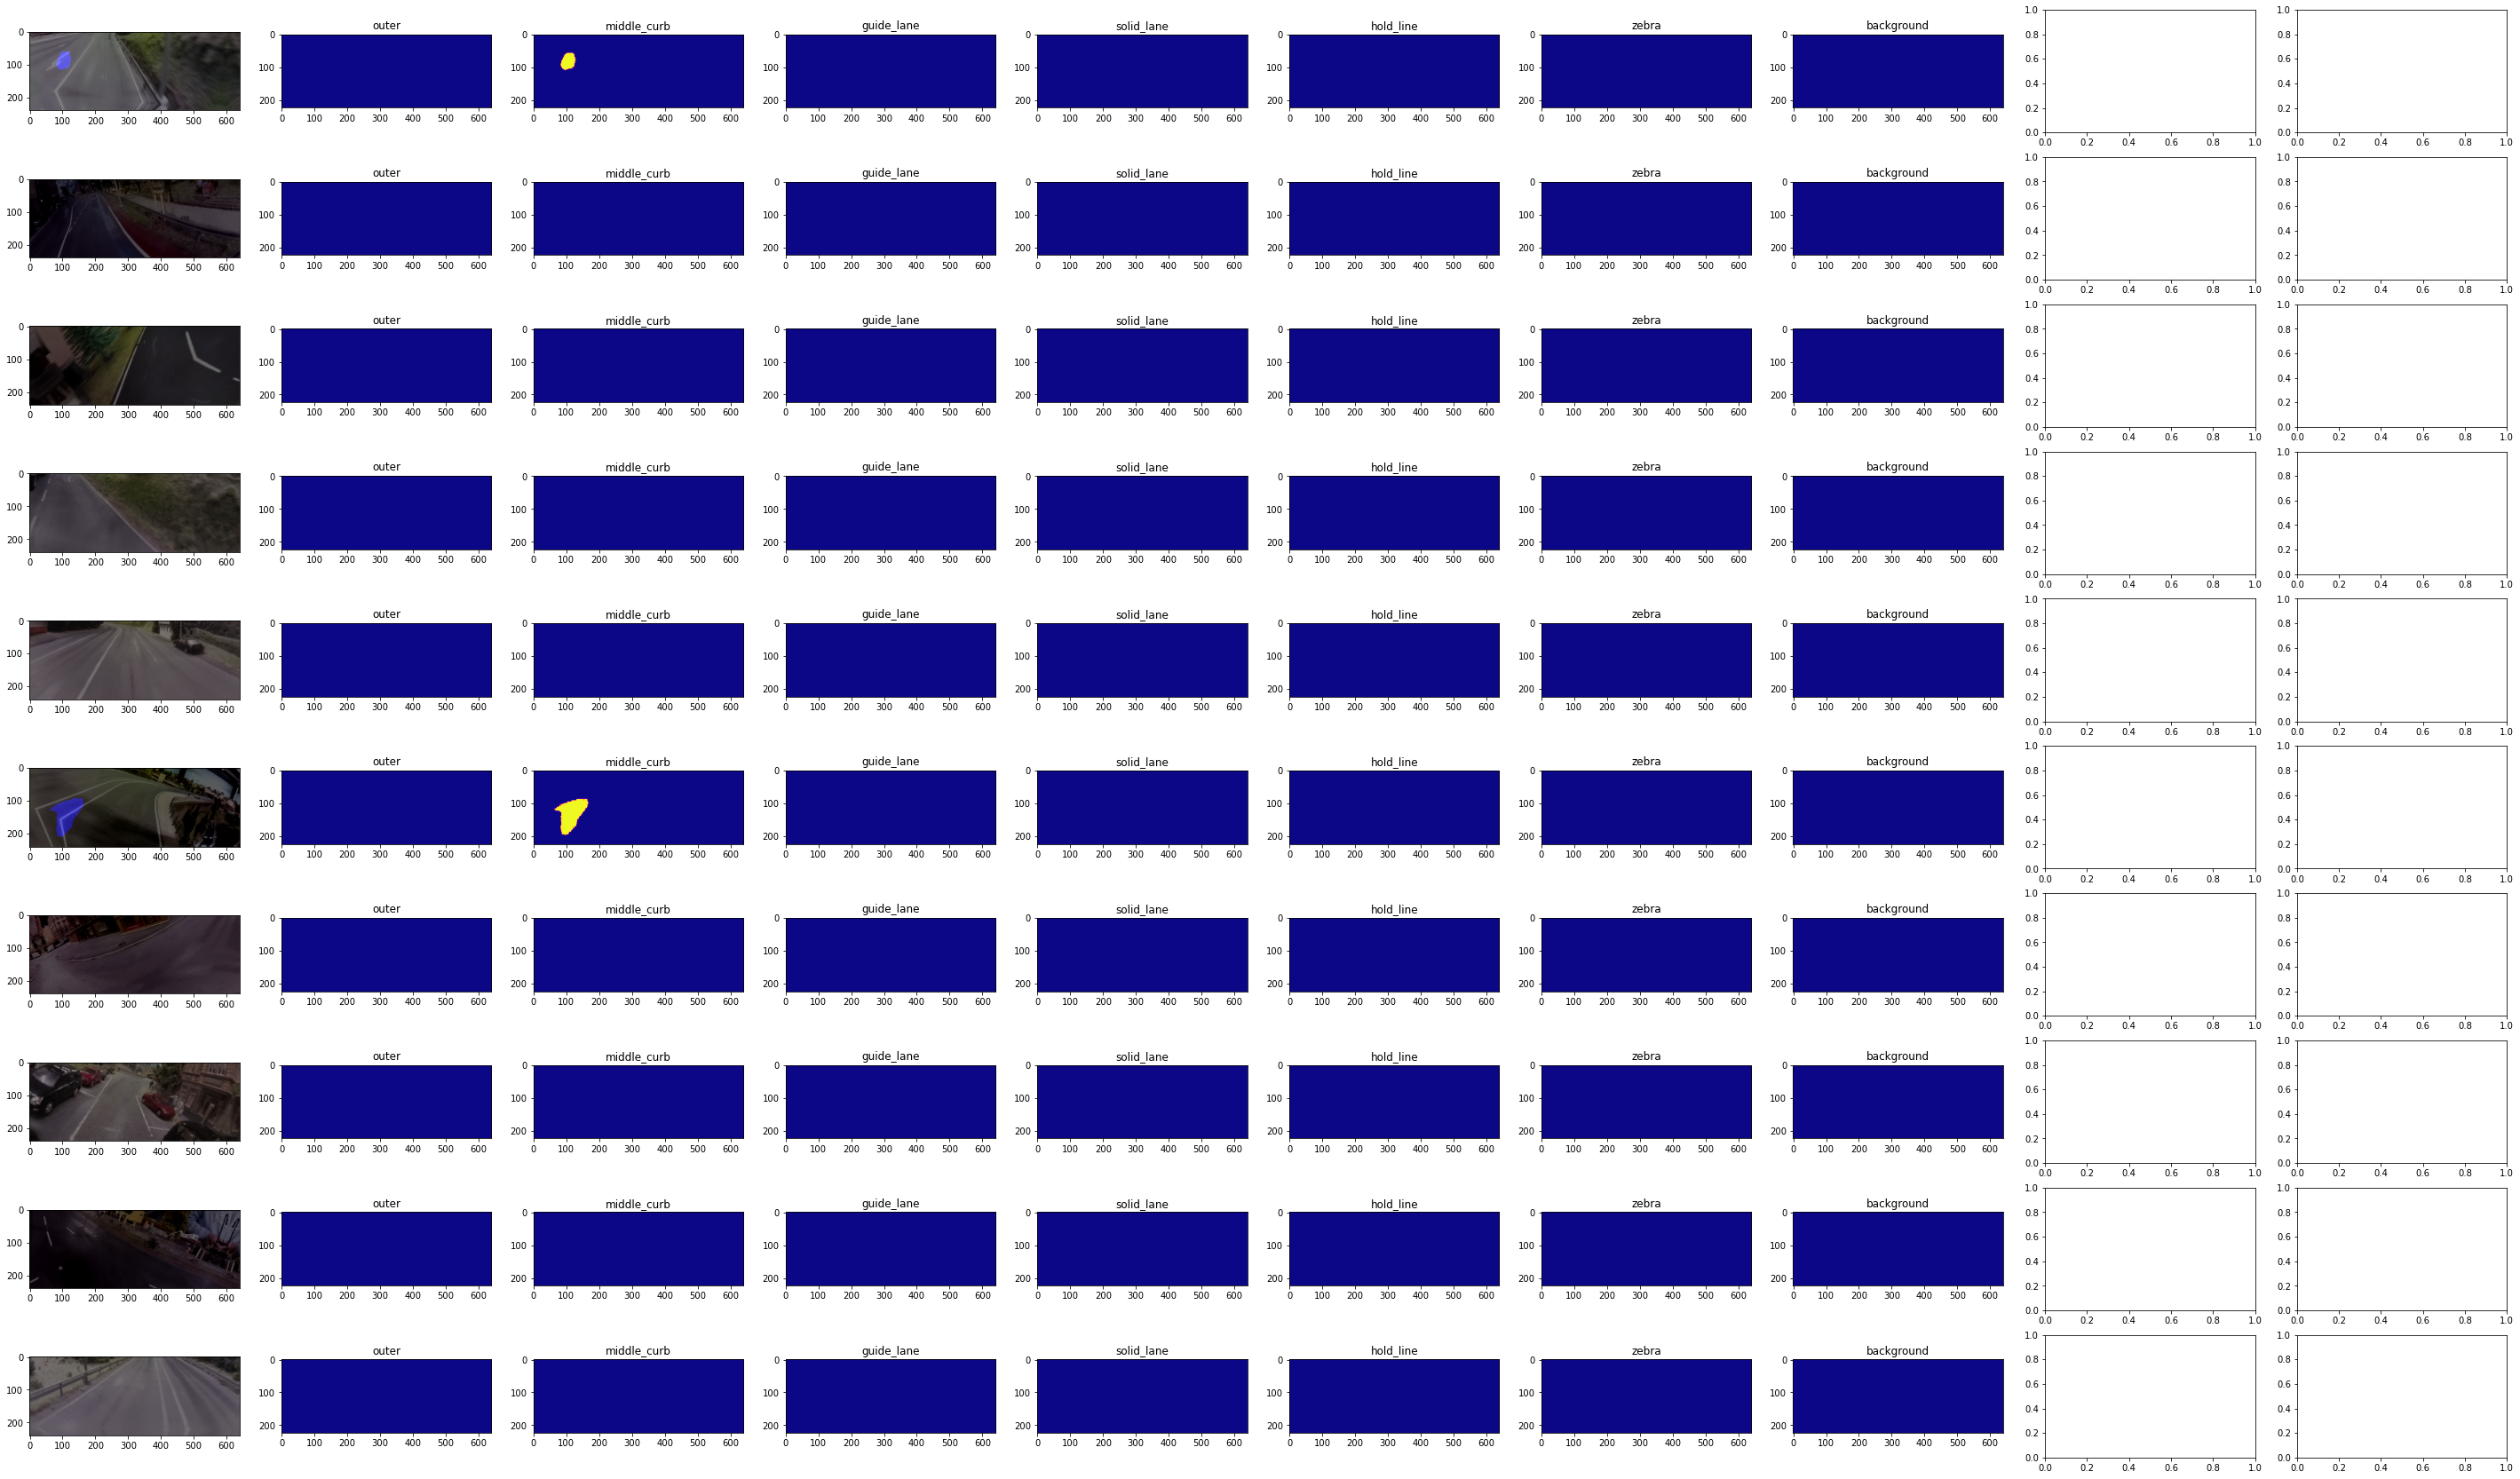

In [25]:
predictions = model.predict(np.array(images))[:cnt]

thres_value = 0.2

def postprocess_channel(img):
    #img = cv2.medianBlur(img, 3)
    _, img = cv2.threshold(img,thres_value,1.0,cv2.THRESH_BINARY)
    return img

f, axs = plt.subplots(len(predictions), 8, figsize=(50,len(predictions)*3))
for i, prediciton in enumerate(predictions):
    #test_img = cv2.resize(test_imgs[i], (x_values, y_values))
    test_img = images[i]
    test_img = test_img.astype(np.float32)
    predicted_lanes = np.sum([postprocess_channel(prediciton[:,:,i]) for i in range(6)], axis=0)
    predicted_lanes = cv2.merge([np.zeros_like(predicted_lanes), np.zeros_like(predicted_lanes), predicted_lanes])
    predicted_lanes = cv2.resize(predicted_lanes, (test_img.shape[1], test_img.shape[0]))
    overlay_image = cv2.addWeighted(test_img, 0.5, predicted_lanes, 0.5, 0)
    axs[i,0].imshow(overlay_image)
    #axs[i,0].imshow(test_imgs[i])

    axs[i,1].imshow(postprocess_channel(prediciton[:,:,0]), cmap='plasma')
    axs[i,1].title.set_text('outer')
    axs[i,2].imshow(postprocess_channel(prediciton[:,:,1]), cmap='plasma')
    axs[i,2].title.set_text('middle_curb')
    axs[i,3].imshow(postprocess_channel(prediciton[:,:,2]), cmap='plasma')
    axs[i,3].title.set_text('guide_lane')
    axs[i,4].imshow(postprocess_channel(prediciton[:,:,3]), cmap='plasma')
    axs[i,4].title.set_text('solid_lane')
    axs[i,5].imshow(postprocess_channel(prediciton[:,:,4]), cmap='plasma')
    axs[i,5].title.set_text('hold_line')
    axs[i,6].imshow(postprocess_channel(prediciton[:,:,5]), cmap='plasma')
    axs[i,6].title.set_text('zebra')
    axs[i,7].imshow(postprocess_channel(prediciton[:,:,6]), cmap='plasma')
    axs[i,7].title.set_text('background')